In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import mobilenet_v3_large
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, model, utils, metrics

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The following is the model architecture I am going to train on FairFace Dataset

Almost the whole model and its architecture - Mobile Net V3 Large pretrained on ImageNet dataset. The last layer is modified and adapted to current FairFace dataset. There are just 3 classes that should predicted at the same time, so the last layer of the model will have three "heads".

In [2]:
show_pic = False

if show_pic:
    Image.open('../model_architecture.png')

In [3]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')
train_label.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


### Initialize Dataset and Dataloader

In [4]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [5]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 'gender' : gender_dict, 'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, {'age_dict' : age_dict, 'race_dict' : race_dict, 'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [1]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels.head()

NameError: name 'train_labels' is not defined

In [7]:
train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], axis=1)

,file,age,gender,race,group,count,group_weight
0,train/1.jpg,6,0,3,603,272,0.003676
1,train/2.jpg,4,1,2,412,931,0.001074
2,train/4.jpg,3,1,2,312,1347,0.000742
3,train/5.jpg,3,1,2,312,1347,0.000742
4,train/7.jpg,5,0,6,506,961,0.001041
...,...,...,...,...,...,...,...
69390,train/86738.jpg,2,0,2,202,510,0.001961
69391,train/86741.jpg,2,0,2,202,510,0.001961
69392,train/86742.jpg,8,1,2,812,93,0.010753
69393,train/86743.jpg,2,1,4,214,663,0.001508


In [7]:
root_dir = Path('/home/himars/Programming/Deep_Learning/fairface_classification/')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 64

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(p=0.5),
                                                                      transforms.RandomPerspective(p=0.5),
                                                                      transforms.RandomAdjustSharpness(2, p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=5)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


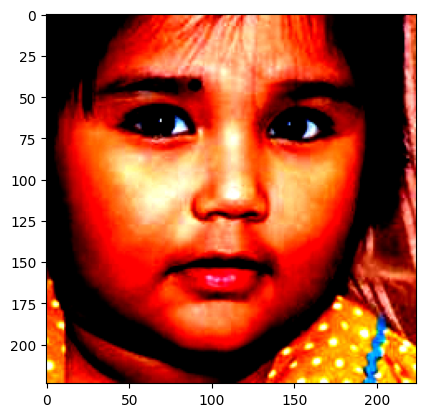

In [8]:
def display_torch_img(dataset, index):
    """Displays a single image from the given dataset at the given index.

    Args:
        dataset: A PyTorch dataset object or the array of tensors.
        index: The index of the image to display.

    Returns:
        None.
    """

    # Check if the dataset is a FairFaceDataset object.
    if type(dataset) == data.FairFaceDataset:

        # Get the image from the dataset.
        img = dataset[index]['image']

        # If the image is a 4D tensor, squeeze it to a 3D tensor.
        if len(dataset[index]['image'].shape) == 4:
            img = torch.squeeze(img)

    # Otherwise, the dataset is assumed to be an array of tensors.
    else:

        # Get the image from the dataset.
        img = dataset[index]

    # Permute the image axes so that the channel axis is the last axis.
    img = img.permute(1, 2, 0)

    # Display the image using Matplotlib.
    plt.imshow(img)
    plt.show()

display_torch_img(fairface_train, 35)

### Sample data

In [9]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[43 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

### First try of training a neural network

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)
model = model.FairFaceMobileNet(mobilenet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [11]:
def train_model(model, criterion, optimizer, scheduler_lr, device, loaders, tensor_writer, mappings, class_weights, n_epochs=25):

    """Fine-tune the model and returns it
    Args:
        model: The model to be trained.
        criterion: The loss function to be used.
        optimizer: The optimizer to be used.
        scheduler_lr: The learning rate scheduler to be used.
        device: The device to be used.
        loaders: A dictionary containing the train and test data loaders.
        tensor_writer: A TensorBoard writer.
        mappings: A dictionary mapping labels to their corresponding indices.
        n_epochs: The number of epochs to train for.

    Returns:
        The trained model.
    """
    # unpack_loss_coefs
    age_weight: float = class_weights['age']
    gender_weight: float = class_weights['gender']
    race_weight: float = class_weights['race']
    # Whether to use learning rate scheduler
    use_lr_scheduler = False

    # Train and validation data pytorch loaders 
    train_loader, test_loader = loaders

    # In the custom implementation of the pytorch dataset train_mode attribute was added for more convenient observance of the image
    data.check_train_mode_off(train_loader, 'train')
    data.check_train_mode_off(test_loader, 'test')

    # Flag that shows whether CCE or BCE is used during training
    cce_mark = type(criterion) == torch.nn.modules.loss.CrossEntropyLoss

    # Initializing of minimal value of validation loss to compare in following code
    valid_loss_min = torch.inf

    # starts training epochs[default = 25]
    for epoch in range(1, n_epochs):
        # Define train and each ANN head losses to compare if it is decreasing during training process
        train_loss = .0
        age_train_loss, race_train_loss, gender_train_loss = .0, .0, .0

        model.train()

        # whether learning rate scheduler is used make the step of it or not
        if use_lr_scheduler:
            scheduler_lr.step()
        
        # ground truths and predictions of the each head of the ANN
        all_age_preds = []
        all_age_labels = []

        all_gender_preds = []
        all_gender_labels = []

        all_race_preds = []
        all_race_labels = []

        # As far as loaders have mini-batch feature and provide samples in that amounts, so iterate over these mini-batches 
        for sample_batched in tqdm(train_loader):
            # read every element of the sample and send it to device[GPU as it is expected]
            image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
            gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

            # get model's predictions
            output = model(image)
            # predict age, gender, race labels
            age_pred = output['age_pred'].to(device)
            gender_pred = output['gender_pred'].to(device)
            race_pred = output['race_pred'].to(device)
            
            # calculate loss[CCE or BCE]
            if cce_mark:
                age_loss = criterion(age_pred, age)
                race_loss = criterion(race_pred, race)
                gender_loss = criterion(gender_pred, gender)
            else:
                # If it is BCE firstly convert to the one-hot encoded vector
                age_dummy = data.get_dummy(age_dict, age, device)
                race_dummy = data.get_dummy(race_dict, race, device)
                gender_dummy = data.get_dummy(gender_dict, gender, device)

                # Then calculate the loss
                age_loss = criterion(age_pred, age_dummy)
                race_loss = criterion(race_pred, race_dummy)
                gender_loss = criterion(gender_pred, gender_dummy)

            # total loss and back propagation
            loss = age_loss * age_weight + race_loss * race_weight + gender_loss * gender_weight

            # add the loss of age, race, gender heads to their total losses of the epoch
            age_train_loss += age_loss
            race_train_loss += race_loss
            gender_train_loss += gender_loss
            train_loss += loss 

            # Clear the gradients of all parameters
            optimizer.zero_grad()
            # Compute the gradients of the loss function with respect to the model's parameters
            loss.backward()
            # optimization step
            optimizer.step()

            # Get Age prediction 
            _, age_predicted = torch.max(torch.softmax(output['age_pred'].data, dim=1), 1)
            # Get Race prediction
            _, race_predicted = torch.max(torch.softmax(output['race_pred'].data, dim=1), 1)
            # Get Gender prediction 
            _, gender_predicted = torch.max(torch.softmax(output['gender_pred'].data, dim=1), 1)

            # Append computed above predictions to the vector for the following comparing
            all_age_preds.extend([i.item() for i in age_predicted])
            all_gender_preds.extend([i.item() for i in gender_predicted])
            all_race_preds.extend([i.item() for i in race_predicted])

            # Append true labels of the dataset to the vector for the following comparing 
            all_age_labels.extend([i.item() for i in age])
            all_gender_labels.extend([i.item() for i in gender])
            all_race_labels.extend([i.item() for i in race])

        # Every epoch log metrics and losses to the tensorboard to track whether the model is training or not
        
        losses = {'loss' : train_loss, 'age' : age_train_loss, 'race' : race_train_loss, 'gender' : gender_train_loss}
        losses = {k : v / len(train_loader) for (k, v) in losses.items()}
        labels = {'age' : all_age_labels, 'race' : all_race_labels, 'gender' : all_gender_labels}
        preds = {'age' : all_age_preds, 'race' : all_race_preds, 'gender' : all_gender_preds}

        print('Training step:')
        tensor_writer = metrics.log_tensorboard(tensor_writer, losses, labels, preds, mappings, epoch, mode='Train')


        # Start evaluation step
        model.eval()

        # Don't compute gradients during this step
        with torch.no_grad():
            # Define vectors of true labels and predictions, current validation loss and each head's loss as like as above
            # for accuracy, precision, recall, f1 etc. comparing
            valid_age_preds = []
            valid_age_labels = []

            valid_gender_preds = []
            valid_gender_labels = []

            valid_race_preds = []
            valid_race_labels = []

            valid_loss = .0
            valid_age_loss, valid_race_loss, valid_gender_loss = .0, .0, .0

            # Iterate over the batches of the validation dataloader
            for sample_batched in tqdm(test_loader):
                # read every element of the sample and send it to device[GPU as it is expected]
                image, age = sample_batched['image'].float().to(device), sample_batched['age'].to(device)
                gender, race = sample_batched['gender'].to(device), sample_batched['race'].to(device)

                # get model's predictions
                output = model(image)

                # predict age, gender, race labels
                age_pred = output['age_pred'].to(device)
                gender_pred = output['gender_pred'].to(device)
                race_pred = output['race_pred'].to(device)

                # calculate loss[CCE or BCE]
                if cce_mark:
                    age_loss = criterion(age_pred, age)
                    race_loss = criterion(race_pred, race)
                    gender_loss = criterion(gender_pred, gender)
                else:
                    # If it is BCE firstly convert to the one-hot encoded vector
                    age_dummy = data.get_dummy(age_dict, age, device)
                    race_dummy = data.get_dummy(race_dict, race, device)
                    gender_dummy = data.get_dummy(gender_dict, gender, device)

                    # Then calculate the loss
                    age_loss = criterion(age_pred, age_dummy)
                    race_loss = criterion(race_pred, race_dummy)
                    gender_loss = criterion(gender_pred, gender_dummy)

                # total loss and back propagation
                loss = age_loss * age_weight + race_loss * race_weight + gender_loss * gender_weight

                # add the loss of age, race, gender heads to their total losses of the epoch
                valid_loss += loss.item()
                valid_age_loss += age_loss
                valid_race_loss += race_loss
                valid_gender_loss += gender_loss

                # Get Age prediction 
                _, age_predicted = torch.max(torch.softmax(output['age_pred'].data, dim=1), 1)
                # Get Race prediction 
                _, race_predicted = torch.max(torch.softmax(output['race_pred'].data, dim=1), 1)
                # Get Gender prediction 
                _, gender_predicted = torch.max(torch.softmax(output['gender_pred'].data, dim=1), 1)

                # Append computed above predictions to the vector for the following comparing
                valid_age_preds.extend([i.item() for i in age_predicted])
                valid_gender_preds.extend([i.item() for i in gender_predicted])
                valid_race_preds.extend([i.item() for i in race_predicted])

                # Append true labels of the dataset to the vector for the following comparing 
                valid_age_labels.extend([i.item() for i in age])
                valid_gender_labels.extend([i.item() for i in gender])
                valid_race_labels.extend([i.item() for i in race])

            # Every epoch log metrics and losses to the tensorboard to track whether the model is training or not
            losses = {'loss' : valid_loss, 'age' : valid_age_loss, 'race' : valid_race_loss, 'gender' : valid_gender_loss}
            losses = {k : v / len(test_loader) for (k, v) in losses.items()}
            labels = {'age' : valid_age_labels, 'race' : valid_race_labels, 'gender' : valid_gender_labels}
            preds = {'age' : valid_age_preds, 'race' : valid_race_preds, 'gender' : valid_gender_preds}

            print('Validation step:')
            tensor_writer = metrics.log_tensorboard(tensor_writer, losses, labels, preds, mappings, epoch, mode='Validation')

        # print training/validation statistics 
        valid_loss /= len(test_loader)
        train_loss /= len(train_loader)

        model_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        checkpoint_dir = Path('../models/checkpoint/')
        best_model_dir = Path('../models/best_model/')

        print(f'End of Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}')
        
        # if validation loss of the current epoch is lower than previous one - save the model
        if valid_loss < valid_loss_min:
            utils.checkpoint(model_state, True, checkpoint_dir, best_model_dir)
            print(f'Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...')
            valid_loss_min = valid_loss
        
        # Do the checkpoint for the model every epoch
        utils.checkpoint(model_state, False, checkpoint_dir, best_model_dir)

    # return trained model
    return model

# map ages
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}
# train the model
best_model = train_model(model, criterion, optimizer, scheduler_lr=scheduler, device=device, loaders=[train_loader, test_loader],tensor_writer=writer, mappings=mappings, class_weights=class_weights, n_epochs=35)

100%|██████████| 1085/1085 [11:22<00:00,  1.59it/s]


Epoch = 1, Loss = 5.42057991027832
Age accuracy = 0.22733626341955473	Race accuracy = 0.16877296635204264	Gender accuracy = 0.6001873333813675
Age loss = 1.814872145652771	Race loss = 1.8000837564468384	Gender Loss = 0.3673360049724579


100%|██████████| 272/272 [00:53<00:00,  5.06it/s]


Validation step:
Epoch = 1, Loss = 4.686245902496226
Age accuracy = 0.31137241339558475	Race accuracy = 0.30439794800853076	Gender accuracy = 0.8280016139258747
End of Epoch: 1 	Training Loss: 5.42057991027832 	Validation Loss: 4.686245902496226
Validation loss decreased (inf --> 4.686245902496226).  Saving model ...


100%|██████████| 1085/1085 [12:25<00:00,  1.45it/s]


Epoch = 2, Loss = 4.572164058685303
Age accuracy = 0.36246127242596726	Race accuracy = 0.2784782765328914	Gender accuracy = 0.810793284818791
Age loss = 1.4882811307907104	Race loss = 1.5478788614273071	Gender Loss = 0.44691571593284607


100%|██████████| 272/272 [00:52<00:00,  5.21it/s]


Validation step:
Epoch = 2, Loss = 4.065680023501901
Age accuracy = 0.4372586316214191	Race accuracy = 0.39667992391492307	Gender accuracy = 0.8714046919130786
End of Epoch: 2 	Training Loss: 4.572164058685303 	Validation Loss: 4.065680023501901
Validation loss decreased (4.686245902496226 --> 4.065680023501901).  Saving model ...


100%|██████████| 1085/1085 [10:54<00:00,  1.66it/s]


Epoch = 3, Loss = 4.078441619873047
Age accuracy = 0.42126954391526766	Race accuracy = 0.3624756826860725	Gender accuracy = 0.8536349881115354
Age loss = 1.2941662073135376	Race loss = 1.5152450799942017	Gender Loss = 0.44701361656188965


100%|██████████| 272/272 [00:44<00:00,  6.16it/s]


Validation step:
Epoch = 3, Loss = 3.7543461480561424
Age accuracy = 0.4645224508617211	Race accuracy = 0.4638307683439968	Gender accuracy = 0.8862182258343421
End of Epoch: 3 	Training Loss: 4.078441619873047 	Validation Loss: 3.7543461480561424
Validation loss decreased (4.065680023501901 --> 3.7543461480561424).  Saving model ...


100%|██████████| 1085/1085 [10:29<00:00,  1.72it/s]


Epoch = 4, Loss = 3.7394795417785645
Age accuracy = 0.45751134807983285	Race accuracy = 0.4476835506880899	Gender accuracy = 0.8722818646876576
Age loss = 1.267806887626648	Race loss = 1.3482282161712646	Gender Loss = 0.21702754497528076


100%|██████████| 272/272 [00:44<00:00,  6.15it/s]


Validation step:
Epoch = 4, Loss = 3.6532944931703457
Age accuracy = 0.44100524525909274	Race accuracy = 0.5237765865467751	Gender accuracy = 0.8926162891232924
End of Epoch: 4 	Training Loss: 3.7394795417785645 	Validation Loss: 3.6532944931703457
Validation loss decreased (3.7543461480561424 --> 3.6532944931703457).  Saving model ...


100%|██████████| 1085/1085 [10:30<00:00,  1.72it/s]


Epoch = 5, Loss = 3.5217459201812744
Age accuracy = 0.48295986742560704	Race accuracy = 0.4941710497874487	Gender accuracy = 0.8834786367893941
Age loss = 1.568158507347107	Race loss = 1.3377001285552979	Gender Loss = 0.4037110209465027


100%|██████████| 272/272 [00:44<00:00,  6.15it/s]


Validation step:
Epoch = 5, Loss = 3.4128764105193756
Age accuracy = 0.4874056141564355	Race accuracy = 0.5368032739639172	Gender accuracy = 0.8956712202432416
End of Epoch: 5 	Training Loss: 3.5217459201812744 	Validation Loss: 3.4128764105193756
Validation loss decreased (3.6532944931703457 --> 3.4128764105193756).  Saving model ...


100%|██████████| 1085/1085 [10:30<00:00,  1.72it/s]


Epoch = 6, Loss = 3.359200954437256
Age accuracy = 0.4987967432812162	Race accuracy = 0.5252107500540385	Gender accuracy = 0.8879314071618992
Age loss = 1.2823917865753174	Race loss = 1.2914317846298218	Gender Loss = 0.36005663871765137


100%|██████████| 272/272 [00:44<00:00,  6.15it/s]


Validation step:
Epoch = 6, Loss = 3.4067573503536335
Age accuracy = 0.4660210963167906	Race accuracy = 0.5623378869099084	Gender accuracy = 0.8967663842296386
End of Epoch: 6 	Training Loss: 3.359200954437256 	Validation Loss: 3.4067573503536335
Validation loss decreased (3.4128764105193756 --> 3.4067573503536335).  Saving model ...


100%|██████████| 1085/1085 [10:31<00:00,  1.72it/s]


Epoch = 7, Loss = 3.227454662322998
Age accuracy = 0.5132214136465163	Race accuracy = 0.5479789610202465	Gender accuracy = 0.893825203544924
Age loss = 1.3118884563446045	Race loss = 1.4286656379699707	Gender Loss = 0.8061882853507996


100%|██████████| 272/272 [00:44<00:00,  6.10it/s]


Validation step:
Epoch = 7, Loss = 3.3657369981793797
Age accuracy = 0.46019943512594386	Race accuracy = 0.5580725113839414	Gender accuracy = 0.8986108709435703
End of Epoch: 7 	Training Loss: 3.227454662322998 	Validation Loss: 3.3657369981793797
Validation loss decreased (3.4067573503536335 --> 3.3657369981793797).  Saving model ...


 68%|██████▊   | 736/1085 [07:09<03:23,  1.71it/s]


KeyboardInterrupt: 

In [ ]:
best_dir = Path('../models/checkpoint/checkpoint.pt')
model, optimizer, epoch = utils.load_ckp(best_dir, model, optimizer)
model = model.to(device)


  0%|          | 0/685 [00:00<?, ?it/s]

100%|██████████| 685/685 [00:38<00:00, 17.81it/s]


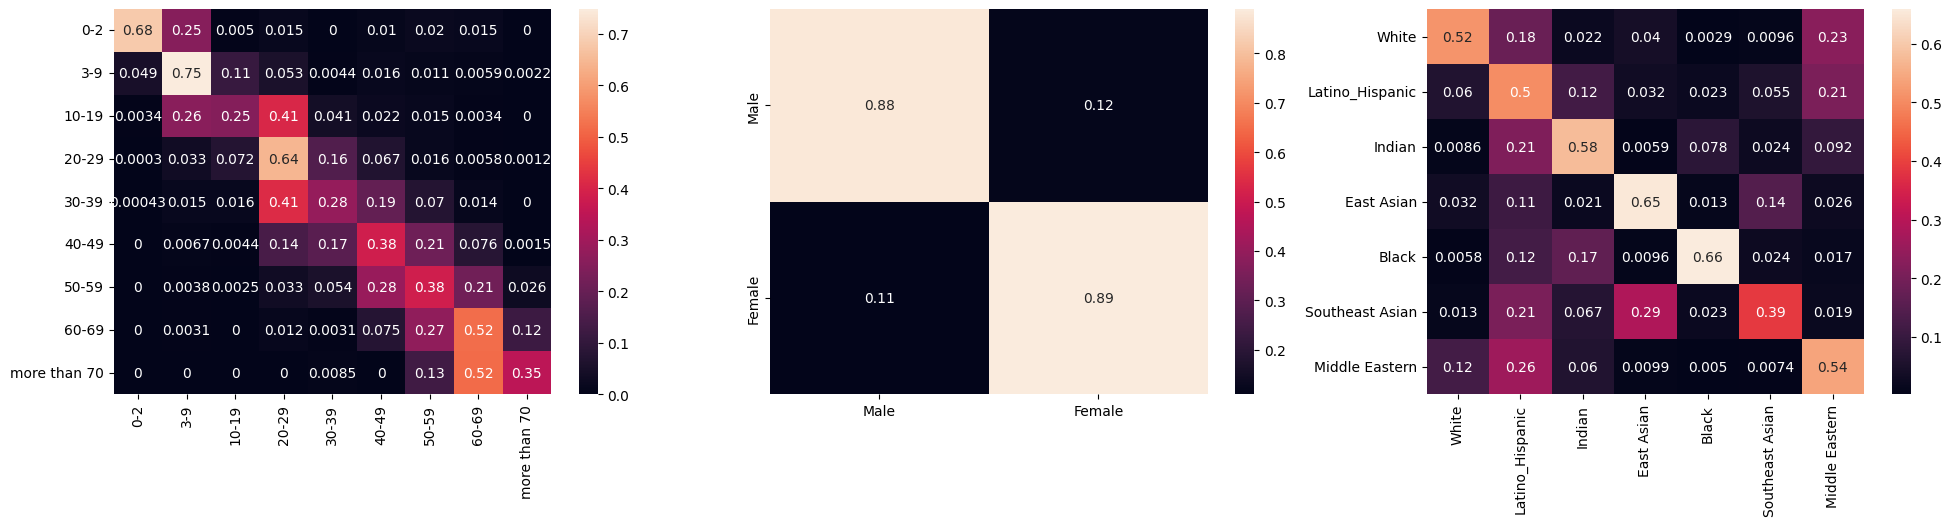

In [ ]:
mappings = {'age_map' : utils.get_mappings(age_dict),
            'gender_map' : utils.get_mappings(gender_dict),
            'race_map' : utils.get_mappings(race_dict)}

ages, genders, races = metrics.build_confusion_matrix(model, val_loader, mappings, device=device)

In [17]:
metrics.calc_measures(model, val_loader, device)

  0%|          | 0/685 [00:00<?, ?it/s]

100%|██████████| 685/685 [00:38<00:00, 17.61it/s]


,accuracy,precision,recall,f1
age,0.478273,0.445095,0.469357,0.449402
gender,0.882783,0.882244,0.883036,0.882530
race,0.544550,0.577024,0.544846,0.550066


In [21]:
def hello_world():
    

  0%|          | 0/685 [00:00<?, ?it/s]

 58%|█████▊    | 398/685 [00:24<00:17, 16.19it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 3.94 GiB total capacity; 2.84 GiB already allocated; 11.00 MiB free; 3.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [21]:
def get_mismatched_classes(model, loader, true_cat, pred_cat, dictionary, output_class, device):
    """Gets the mismatched images for the given model, loader, true category, predicted category, dictionary, output class, and device.

    Args:
        model: The model to evaluate.
        loader: The loader to use to load the data.
        true_cat: The true category.
        pred_cat: The predicted category.
        dictionary: A dictionary mapping category names to indices.
        output_class: The output class.
        device: The device to use.

    Returns:
        A list of mismatched images.
    """
    # Initialize a list to store the mismatched images.
    mismatched_img = []
    # Set the model to evaluation mode.
    model.eval()
    # Iterate over the loader.
    with torch.no_grad():   
          
        for batch in tqdm(loader):
            # Move the images and labels to the device.
            image = batch['image'].to(device)
            age = batch[output_class].to(device)
            # Make a prediction.
            output = model(image)

            # Get the predicted class.
            _, predicted = torch.max(torch.softmax(output[f'{output_class}_pred'].data, dim=1), 1)
            # Iterate over the true and predicted classes.
            for true, pred, img in zip(age, predicted, image):
                # If the true and predicted categories are not the same, add the image to the list of mismatched images.
                if dictionary[true_cat] == int(true) and dictionary[pred_cat] == int(pred):
                    mismatched_img.append(img)
                    
    # Return the list of mismatched images.
    return mismatched_img

mism_imgs = get_mismatched_classes(model, val_loader, '30-39', '20-29', age_dict, 'age', device)
mism_imgs = [i.cpu() for i in mism_imgs]

  0%|          | 0/685 [00:00<?, ?it/s]

 58%|█████▊    | 398/685 [00:24<00:17, 16.19it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 3.94 GiB total capacity; 2.84 GiB already allocated; 11.00 MiB free; 3.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def show(imgs):
    img_batch = []
    cur_batch = 1
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(imgs):
        img = np.array(img).transpose(1, 2, 0)
        img_batch.append(img)
        
        if (i + 1) % 20 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.title('True category = 30-39; Mismatched one = 20-29')
            columns = 4
            rows = 5
            for i in range(1, columns*rows + 1):
                img = img_batch[i - 1]
                ax = fig.add_subplot(rows, columns, i)
                ax.set_axis_off()
                plt.imshow(img)
            fig.set_tight_layout(tight=True)
            fig.savefig(f'../mismatched_examples/mismatched_age_number_{cur_batch}.png')
            plt.close()

            cur_batch += 1
            img_batch = []

show(mism_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [29]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

class Unnormalize(nn.Module):
    def __init__(self, mean, std):
        super(Unnormalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        # Assuming x is a batch of normalized images with shape (batch_size, channels, height, width)
        # Unnormalize the input batch
        x = x * self.std + self.mean
        return x

# Example usage:
if __name__ == "__main__":
    # Example mean and std values for ImageNet normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Create an instance of the Unnormalize module
    unnormalize = Unnormalize(mean, std)

    # # Dummy normalized input tensor
    normalized_input = mism_imgs[0].unsqueeze(0).to(dtype=torch.long, device=device)

    # Perform unnormalize operation
    unnormalized_output = unnormalize(mism_imgs)

    # Check the output
    print(unnormalized_output)

TypeError: only integer tensors of a single element can be converted to an index